# Level3. 単語の共起行列から特徴ベクトルを生成する

In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import re
import nltk
import scipy.spatial.distance as distance
import sklearn.feature_extraction.text as fe_text

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import wordpunct_tokenize, sent_tokenize
# nltk.download('stopwords')

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### 便利関数

In [2]:
def cosine_similarity(vectors):
    vectors = np.array(vectors)
    distances = []
    for i in range(len(vectors)):
        temp = []
        for j in range(len(vectors)):
            temp.append(1 - distance.cosine(vectors[i], vectors[j]))
        distances.append(temp)
    return distances

### データの読み込み

In [3]:
docs = {}
for idx in range(13):
    with open(f'../dataset/ch{idx:02}.html') as f:
        docs[f'ch{idx:02}'] = f.read()

In [4]:
print(docs['ch00'][:300])

<?xml version="1.0" encoding="ascii" ?>

<script language="javascript" type="text/javascript">

function astext(node)
{
    return node.innerHTML.replace(/(<([^>]+)>)/ig,"")
                         .replace(/&gt;/ig, ">")
                         .replace(/&lt;/ig, "<")
                         .re


### 前処理

In [5]:
def preprocessing(raw_text):
    bodytext = re.findall(r'<body>.+</body>', raw_text.replace('\n', ' '))[0]
    body_text_removed_HTMLTag = re.sub('<[^>]+>', '', bodytext)
#     sentence_list = body_text_removed_HTMLTag.split('. ') # ピリオドも削除されてしまうが、ストップワードで消えるので問題ない
    return body_text_removed_HTMLTag

In [6]:
for k, d in docs.items():
    docs[k] = preprocessing(d)

In [7]:
print(docs['ch00'][:300])

  Preface                                    This is a book about Natural Language Processing. By &quot;natural language&quot; we mean a language that is used for everyday communication by humans; languages like English, Hindi or Portuguese. In contrast to artificial languages such as programming la


前処理は終わった。  
これでHTMLのヘッダーとHTMLタグは除去できたはず。

共起行列を作成する際に使いやすいように一つの文書としてまとめる

In [8]:
sentence = " ".join(list(docs.values()))

## 共起行列を作成する

In [9]:
def preprocess(text):
    """テキストに対する前処理。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.66より。

    :param text:
    :return:
      courpus(list): id_to_wordのidに基づいたone-hot vector。
      word_to_id(dict): 単語をkeyとして、idを参照する辞書。
      id_to_word(dict): idをkeyとして、単語を参照する辞書。
    """
    text = text.lower()
    text = text.replace('.', ' .')
    text = text.replace('"', '')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [10]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    """共起行列を作成。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.72より。

    :param corpus(str): テキスト文。
    :param vocab_size: 語彙数。
    :param window_size: 共起判定の範囲。
    :return:
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

共起行列を作成する

In [11]:
corpus, word_to_id, id_to_word = preprocess(sentence)
vocab_size = len(word_to_id)

co_matrix = create_co_matrix(corpus, vocab_size, window_size=2)
df = pd.DataFrame(co_matrix, index=word_to_id.keys(), columns=word_to_id.keys())
df

,,preface,this,is,a,book,about,natural,language,processing,...,striving,fluency,unfortunate,concluded,"broadly,","expedient,","society,",pathway,present:,hacking!
,59516,4,303,139,411,15,29,7,34,22,...,0,0,0,0,0,0,0,0,0,2
preface,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
this,303,0,0,211,63,42,19,0,0,1,...,0,0,0,0,0,0,0,0,0,0
is,139,0,211,12,513,12,10,5,21,6,...,0,0,0,0,0,0,0,0,0,0
a,411,0,63,513,28,7,15,6,37,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"expedient,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"society,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pathway,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
present:,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 共起行列のcos類似度を算出する
natural, language, text, count に加え、1個以上の単語を選べ。  
それらの単語についてマトリックス表記で単語間類似度（コサイン類似度）を記せ。表示有効桁は3桁とせよ。

In [12]:
df[['natural', 'language', 'text', 'count', 'processing']].T

,,preface,this,is,a,book,about,natural,language,processing,...,striving,fluency,unfortunate,concluded,"broadly,","expedient,","society,",pathway,present:,hacking!
natural,7,0,0,5,6,1,1,0,99,31,...,0,0,0,0,0,0,0,0,0,0
language,34,0,0,21,37,0,6,99,0,60,...,0,0,0,0,0,0,0,0,0,0
text,119,0,8,24,135,0,1,1,1,6,...,0,0,0,0,0,0,0,0,0,0
count,9,0,1,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
processing,22,0,1,6,12,0,0,31,60,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
vectors = df[['natural', 'language', 'text', 'count', 'processing']].T.values

In [14]:
cos_similarity_matrix = np.array(cosine_similarity(vectors))
cos_similarity_matrix

array([[1.        , 0.3932209 , 0.32802631, 0.23920726, 0.74648433],
       [0.3932209 , 1.        , 0.69390749, 0.48966133, 0.60231901],
       [0.32802631, 0.69390749, 1.        , 0.6974668 , 0.50592242],
       [0.23920726, 0.48966133, 0.6974668 , 1.        , 0.38509679],
       [0.74648433, 0.60231901, 0.50592242, 0.38509679, 1.        ]])

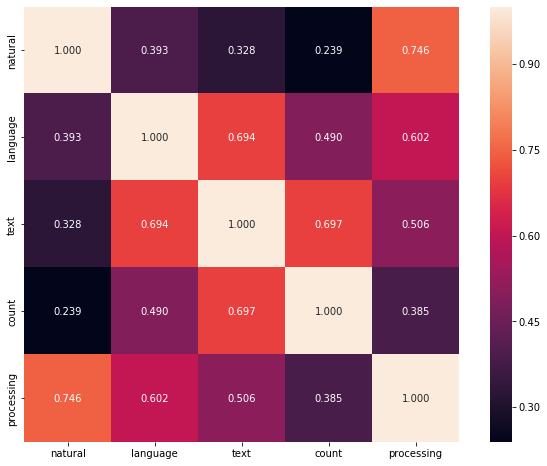

In [15]:
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(cos_similarity_matrix, annot=True, fmt='.3f', square=True, ax=ax,
           xticklabels=['natural', 'language', 'text', 'count', 'processing'],
           yticklabels=['natural', 'language', 'text', 'count', 'processing'])
ax.set_ylim(5, 0)
# plt.title("natural, language, text, count, processing という単語の類似度のヒートマップ")
plt.yticks(va="center")
plt.show()

類似度のヒートマップを見ると、naturalとprocessingの類似度がもっとも高いという結果になった。  
原因としては、natural language, language processing という用語が多く使われているため、unigramの時に文脈がほぼ固定されているからだと考えられる。

## naturalとprocessingの類似度がもっとも高くなった原因を考える

In [16]:
df_target = df[['natural', 'language', 'text', 'count', 'processing']][df[['natural', 'language', 'text', 'count', 'processing']].T.apply(lambda x: sum(x) > 50)].T.drop('', axis=1)
df_target

,is,a,natural,language,processing,.,for,in,to,and,from,with,of,the
natural,5,6,0,99,31,12,7,13,7,3,16,14,28,22
language,21,37,99,0,60,71,27,30,18,22,20,22,76,66
text,24,135,1,1,6,100,22,78,39,40,37,11,99,125
count,0,6,0,0,0,2,2,1,7,2,0,0,5,17
processing,6,12,31,60,0,32,11,5,5,10,3,20,13,21


使用されている単語を見てみる

In [17]:
print("naturalのn=1の文脈")
pprint(re.findall(r'([a-z|A-Z]+ natural [a-z|A-Z]+)', sentence)[-100:])

naturalのn=1の文脈
['of natural language',
 'more natural human',
 'on natural language',
 'in natural language',
 'analyze natural language',
 'to natural language',
 'for natural language',
 'of natural language',
 'of natural language',
 'of natural language',
 'a natural language',
 'of natural language',
 'most natural choice',
 'processing natural language',
 'a natural and',
 'visualizing natural language',
 'from natural language',
 'in natural language',
 'in natural language',
 'in natural language',
 'most natural way',
 'to natural language',
 'in natural language',
 'of natural language',
 'of natural language',
 'of natural language',
 'that natural language',
 'is natural language',
 'Many natural language',
 'the natural language',
 'of natural languages',
 'of natural language',
 'processing natural language',
 'is natural to',
 'represent natural language',
 'a natural language',
 'a natural language',
 'of natural language',
 'of natural language',
 'via natural language

In [18]:
print("processingのn=1の文脈")
pprint(re.findall(r'([a-z|A-Z]+ processing [a-z|A-Z]+)', sentence)[-100:])

processingのn=1の文脈
['language processing has',
 'language processing or',
 'language processing software',
 'language processing that',
 'for processing linguistic',
 'Language processing task',
 'String processing tokenize',
 'Language processing tasks',
 'with processing annotated',
 'language processing from',
 'language processing at',
 'language processing tasks',
 'language processing system',
 'the processing components',
 'linguistic processing task',
 'of processing a',
 'were processing the',
 'is processing some',
 'is processing user',
 'text processing functions',
 'for processing the',
 'for processing all',
 'linguistic processing we',
 'for processing strings',
 'for processing texts',
 'linguistic processing tasks',
 'language processing tasks',
 'manual processing is',
 'than processing any',
 'the processing of',
 'text processing is',
 'language processing work',
 'of processing words',
 'text processing with',
 'of processing the',
 'for processing natural',
 'reada

In [19]:
print("languageのn=1の文脈")
pprint(re.findall(r'([a-z|A-Z]+ language [a-z|A-Z]+)', sentence)[-100:])

languageのn=1の文脈
['perform language processing',
 'about language from',
 'new language data',
 'new language data',
 'useful language processing',
 'about language from',
 'of language is',
 'a language processing',
 'new language data',
 'for language problems',
 'the language technologies',
 'natural language text',
 'natural language can',
 'natural language sentences',
 'natural language is',
 'electronic language data',
 'the language of',
 'that language provides',
 'the language will',
 'natural language understanding',
 'natural language applications',
 'natural language questions',
 'programming language compilers',
 'of language could',
 'natural language meaning',
 'natural language question',
 'query language such',
 'a language designed',
 'natural language query',
 'natural language understanding',
 'query language rather',
 'natural language are',
 'query language such',
 'natural language have',
 'one language to',
 'natural language semantics',
 'natural language which